In [45]:
import os, re
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, transpile, execute, Aer
from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance, algorithm_globals

In [46]:
def rnd_seed(backend, seed):
    algorithm_globals.random_seed = seed
    np.random.seed = seed
    quantum_instance = QuantumInstance(
        backend=backend, seed_transpiler=seed, seed_simulator=seed
    )

def get_g_circuit(round, distribution, prefix):
    entangler_map = [(0,1), (1,2)]
    init_dist = QuantumCircuit(3)
    ansatz = TwoLocal(3, ["ry", "rz", "ry"], "cx", entanglement=entangler_map, reps=1)
    npy_name = f"{prefix}_round{round}.npy"
    init_params = np.load(npy_name)
    g_circuit = ansatz.compose(init_dist, front=True)
    para_dict = {}
    for i in range(len(g_circuit.parameters)):
        para_dict[g_circuit.parameters[i]] = init_params[i]
    g_circuit = g_circuit.bind_parameters(para_dict)
    return g_circuit

In [51]:
distribution = "lognormal"
prefix = f"{distribution}/result_U_HFalse_{distribution}_r50_e3_reps1"
backend = Aer.get_backend('qasm_simulator')
entropy_dict = np.load(f"{prefix}_entropy.npy", allow_pickle=True).item()
entropy_dict = {k: v for k, v in sorted(entropy_dict.items(), key=lambda item: item[1])}
entropy_item = list(entropy_dict.items())

Round 24 : Entropy = 0.1675


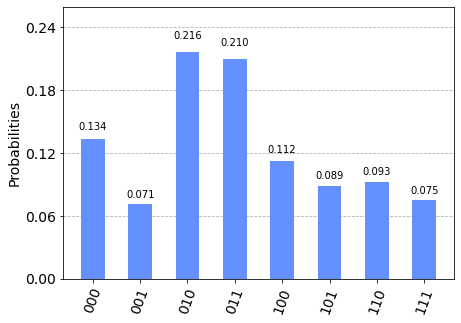

In [52]:
i = 0
round_idx = re.search("round", entropy_item[i][0]).start() + 5
round = entropy_item[i][0][round_idx:]

print(f"Round {round} : Entropy = {entropy_item[i][1]}")
rnd_seed(backend, seed=round)
qc = get_g_circuit(round, distribution, prefix)
qc.measure_all()

job = execute(qc, backend, shots=1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)